In [43]:
import sys
sys.path.append('/Users/eneminova/AsyncMethods')

from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState
from LinearRegression import linear_regression_loss, linear_regression_gradient, accuracy_fn
from LogisticRegression import logistic_regression_loss, logistic_regression_gradient
from MLP_mnist import SimpleNN, loss_from_vector, gradient_from_vector

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from functools import partial
import scipy.stats as sps

from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import ortho_group
from functools import partial
from collections import defaultdict
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**LinReg on diabetes**

In [44]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = np.hstack((diabetes_X, np.ones((len(diabetes_X), 1))))

n_workers = 4
time_distributions = [sps.norm(i+1, scale=26) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10


n_iterations = 5000

w = np.zeros(diabetes_X.shape[1])
lr = 0.001

In [45]:
minibatch_sgd = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
async_gd = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd.set_batch_size(5)

methods = {'Minibatch SGD' : minibatch_sgd,
           'Async GD' : async_gd,
           'Rennala SGD' : rennala_sgd}

In [46]:
n_works = [1, 4, 10, 20, 100, 1000]
times = {}
losses = {}
for i in n_works:
    time_distributions = [sps.norm(i+1, scale=1) for i in range(i)]
    batch_sizes = np.arange(1, i + 1) * 10
    
    async_gd = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(i)], \
                                  learning_rate=lr)
    
    current_x, loss_history, computation_times, x_history = async_gd.run_steps(n_iterations)
    
    times[i] = computation_times
    losses[i] = loss_history

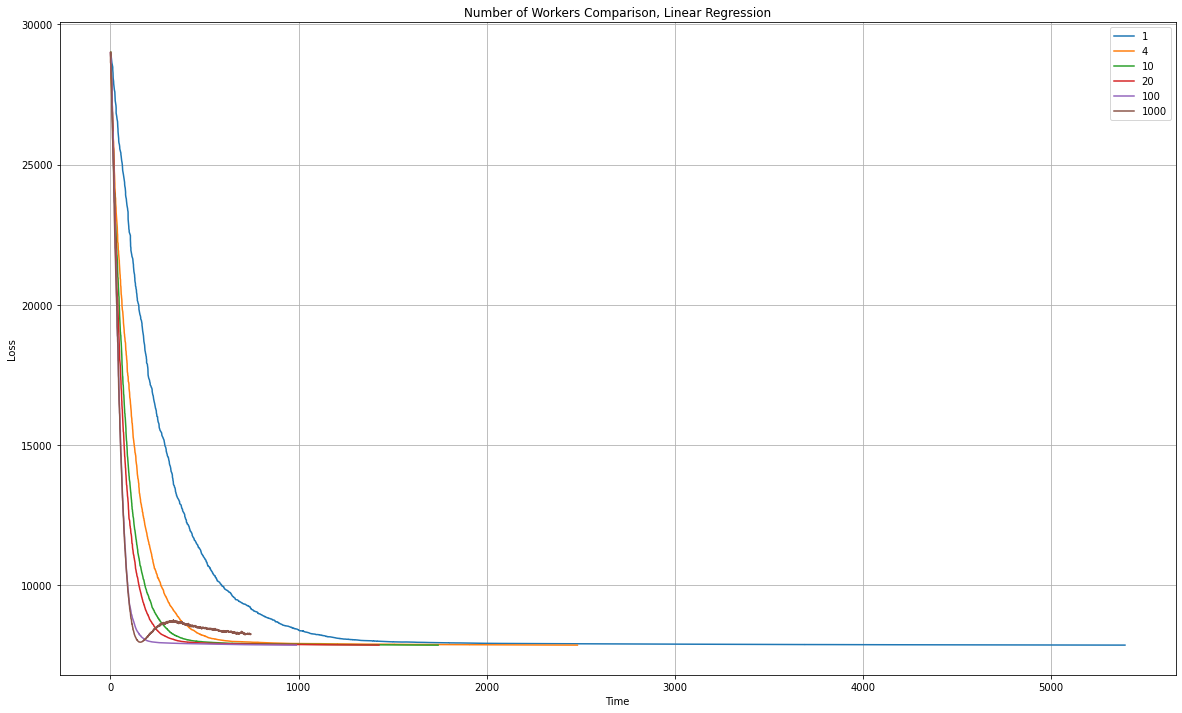

In [47]:
plt.figure(figsize=(20, 12))
for i in n_works:
    plt.plot(times[i], losses[i], label=i)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Number of Workers Comparison, Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
print(times)

{1: [0.3971211926881836, 2.0905925139083235, 2.9196942335314975, 2.921760615634622, 5.090078124164272, 5.6761794343721235, 7.340748001070042, 9.002114372388528, 9.002114372388528, 10.648379427482014, 12.14843093552373, 12.14843093552373, 12.618561167005653, 14.473921512978574, 17.495444156826526, 17.716449109897297, 18.473506835745198, 19.704268837376944, 20.2580504917281, 22.026488284855198, 23.115740892483085, 23.115740892483085, 24.150748818199464, 26.00342875902173, 28.41860031376754, 29.979770288784167, 31.720309570624103, 32.695933334402795, 35.18340327369295, 36.62617246304895, 37.158847656982516, 38.24701584485865, 39.48249552044226, 40.60523715978567, 42.956614065570996, 46.11515302096633, 48.33290379529873, 50.33703433199051, 53.664391812058945, 55.484725700943216, 57.18013489085627, 57.918078512344266, 60.98082398994964, 60.98082398994964, 61.17699499417555, 62.45259761057185, 62.51421430846685, 63.099625143789766, 64.22233377987638, 66.058601574711, 66.73951234415519, 68.34

In [37]:
times = dict()
losses = dict()
accs = dict()
for method_name in methods:
    w = np.zeros(diabetes_X.shape[1])
    current_x, loss_history, computation_times, x_history = methods[method_name].run_steps(n_iterations)
    accuracy = methods[method_name].restore_accuracies()
    times[method_name] = computation_times
    losses[method_name] = loss_history
    accs[method_name] = accuracy

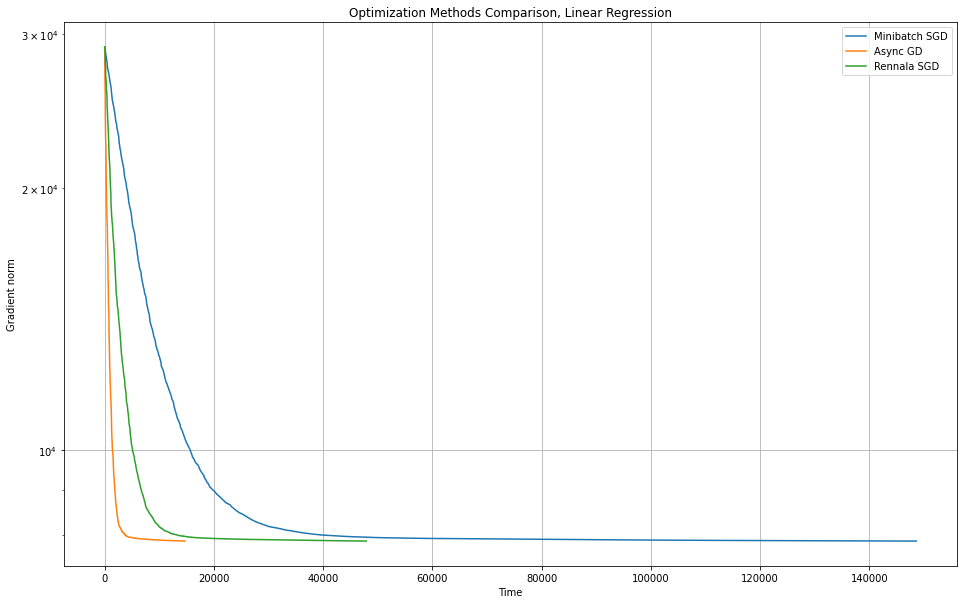

In [39]:
plt.figure(figsize=(16, 10))
for method_name in methods:
    plt.plot(times[method_name], losses[method_name], label=method_name)

plt.xlabel('Time')
plt.ylabel('Gradient norm')
plt.yscale('log')
plt.title('Optimization Methods Comparison, Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
minibatch_sgd = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
async_gd = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd.set_batch_size(5)

methods = {'Minibatch SGD' : minibatch_sgd,
           'Async GD' : async_gd,
           'Rennala SGD' : rennala_sgd}

In [129]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = np.hstack((diabetes_X, np.ones((len(diabetes_X), 1))))

n_workers = 4
time_distributions = [sps.norm(i+1, scale=26) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10


n_iterations = 1000

w = np.zeros(diabetes_X.shape[1])
lr = 0.01

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sps
from functools import partial

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def compare_params(method_type, params, param_to_check):
    if param_to_check == "number of workers":
        
        times = dict()
        losses = dict()
        accs = dict()
        grads = dict()
        
        for param in tqdm(params):
            w = np.zeros(diabetes_X.shape[1]) 
            i = 0
            time_distributions = [sps.norm(i+1, scale=1) for i in range(param)]
            batch_sizes = np.arange(1, param + 1) * 10
            
            if method_type == "MinibatchSGD":
                
                print(param)
                
                method = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(param)], \
                                  learning_rate=lr)
                title = 'Number of Workers Comparison, Linear Regression, Minibatch'

                
            if method_type == "AsynchronousGD":
                
                print(param)
                
                method = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(param)], \
                                  learning_rate=lr)
                title = 'Number of Workers Comparison, Linear Regression, AsynchronousGD'
   
            if method_type == "RennalaSGD":
                
                print(param)
                
                method = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(param)], \
                                  learning_rate=lr)
                method.set_batch_size(5)
                title = 'Number of Workers Comparison, Linear Regression, RennalaSGD'

            
            current_x, loss_history, computation_times, x_history = method.run_steps(n_iterations)
            accuracy = method.restore_accuracies()
            _, grad_norm = method.restore_gradients()
            times[param] = computation_times
            losses[param] = loss_history
            accs[param] = accuracy
            grads[param] = grad_norm
        
        plt.figure(figsize=(20, 12))
        for i in params:
            smoothed_grads = moving_average(grads[i])  # Применяем сглаживание
            smoothed_times = moving_average(times[i])  # Применяем сглаживание
            plt.plot(smoothed_times, smoothed_grads, label=f'Workers: {i}')
        
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Grad Norm')
        plt.legend()
        plt.grid(True)
        plt.show()

number_of_workers_array = [1, 2, 4, 8]

compare_params(method_type="MinibatchSGD", params=number_of_workers_array, param_to_check="number of workers")
compare_params(method_type="AsynchronousGD", params=number_of_workers_array, param_to_check="number of workers")
compare_params(method_type="RennalaSGD", params=number_of_workers_array, param_to_check="number of workers")


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.46it/s]

[1, 1, 1, 1]
constant
[<scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3bb0>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3a00>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3520>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3f70>]
distr


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


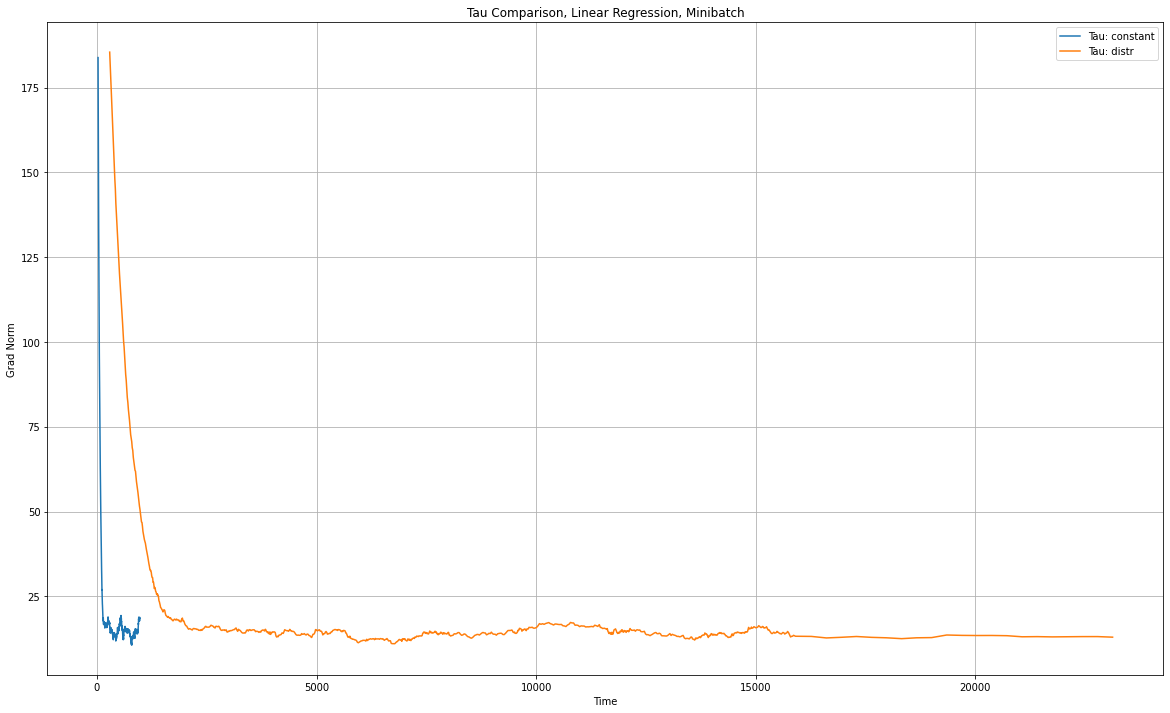

 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.58it/s]

[1, 1, 1, 1]
constant
[<scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3bb0>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3a00>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3520>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3f70>]
distr


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


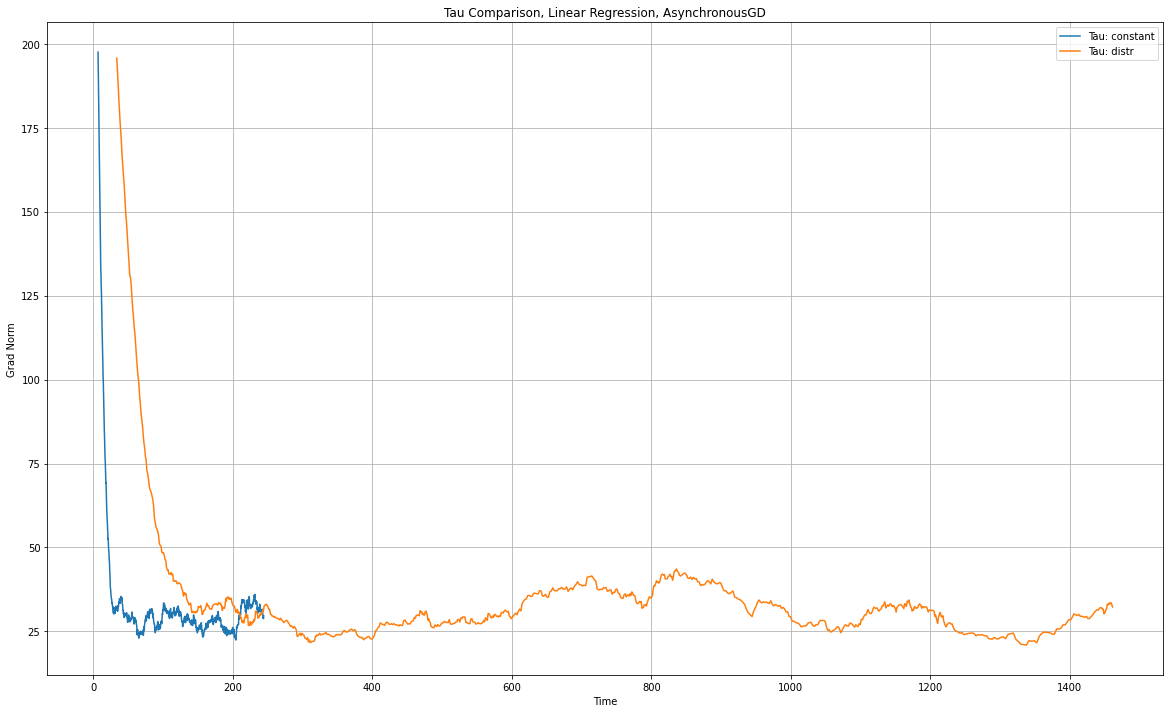

  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1, 1, 1, 1]
constant


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.28it/s]

[<scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3bb0>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3a00>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3520>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce93c3f70>]
distr


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]


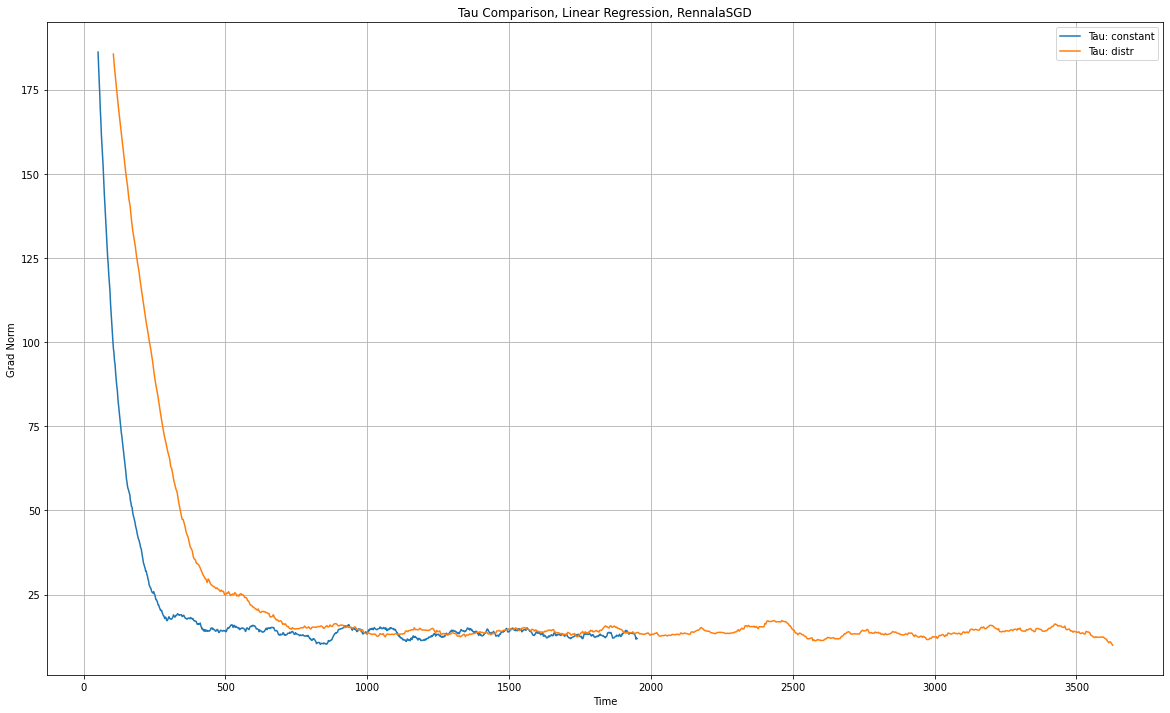

In [152]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sps
from functools import partial

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def compare_params(method_type, params, param_to_check):
    if param_to_check == "tau":
        
        times = dict()
        losses = dict()
        accs = dict()
        grads = dict()
        
        for param in tqdm(params):
            w = np.zeros(diabetes_X.shape[1]) 

            time_distributions = params[param]
            print(time_distributions)
            batch_sizes = np.arange(1, 4 + 1) * 10
            
            if method_type == "MinibatchSGD":
                
                print(param)
                
                method = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(4)], \
                                  learning_rate=lr)
                title = 'Tau Comparison, Linear Regression, Minibatch'

                
            if method_type == "AsynchronousGD":
                
                print(param)
                
                method = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(4)], \
                                  learning_rate=lr)
                title = 'Tau Comparison, Linear Regression, AsynchronousGD'
   
            if method_type == "RennalaSGD":
                
                print(param)
                
                method = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(4)], \
                                  learning_rate=lr)
                method.set_batch_size(5)
                title = 'Tau Comparison, Linear Regression, RennalaSGD'

            
            current_x, loss_history, computation_times, x_history = method.run_steps(n_iterations)
            accuracy = method.restore_accuracies()
            _, grad_norm = method.restore_gradients()
            times[param] = computation_times
            losses[param] = loss_history
            accs[param] = accuracy
            grads[param] = grad_norm
        
        plt.figure(figsize=(20, 12))
        for i in params:
            smoothed_grads = moving_average(grads[i])  # Применяем сглаживание
            smoothed_times = moving_average(times[i])  # Применяем сглаживание
            plt.plot(smoothed_times, smoothed_grads, label=f'Tau: {i}')
        
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Grad Norm')
        plt.legend()
        plt.grid(True)
        plt.savefig('tau.png')
        plt.show()
        

tau_params = {"constant":[1 for i in range(4)], "distr": [sps.cauchy(i+1, scale=2) for i in range(4)]}


compare_params(method_type="MinibatchSGD", params=tau_params, param_to_check="tau")
compare_params(method_type="AsynchronousGD", params=tau_params, param_to_check="tau")
compare_params(method_type="RennalaSGD", params=tau_params, param_to_check="tau")



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2


 40%|██████████████████                           | 2/5 [00:00<00:01,  2.71it/s]

4
8


 60%|███████████████████████████                  | 3/5 [00:01<00:00,  2.07it/s]

16


 80%|████████████████████████████████████         | 4/5 [00:02<00:00,  1.38it/s]

32


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


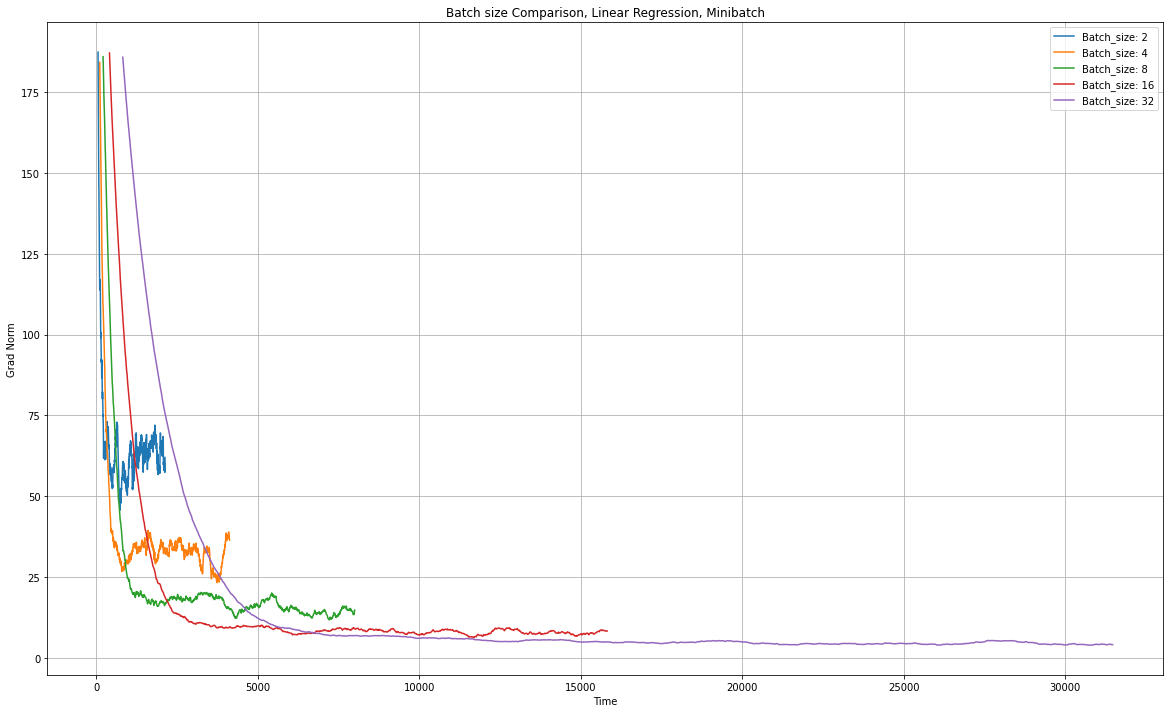

 20%|█████████                                    | 1/5 [00:00<00:00,  4.76it/s]

2
4


 60%|███████████████████████████                  | 3/5 [00:00<00:00,  4.91it/s]

8
16


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]

32


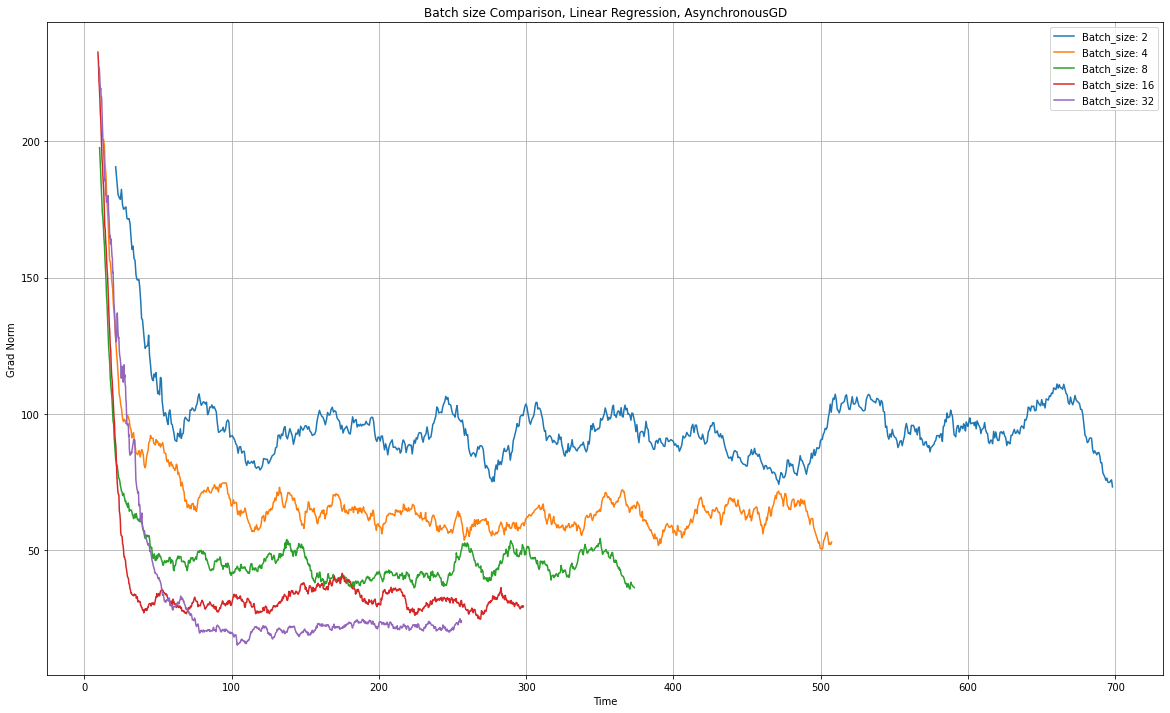

  0%|                                                     | 0/5 [00:00<?, ?it/s]

2


 20%|█████████                                    | 1/5 [00:00<00:02,  1.76it/s]

4


 60%|███████████████████████████                  | 3/5 [00:02<00:01,  1.32it/s]

8
16


 80%|████████████████████████████████████         | 4/5 [00:03<00:01,  1.01s/it]

32


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


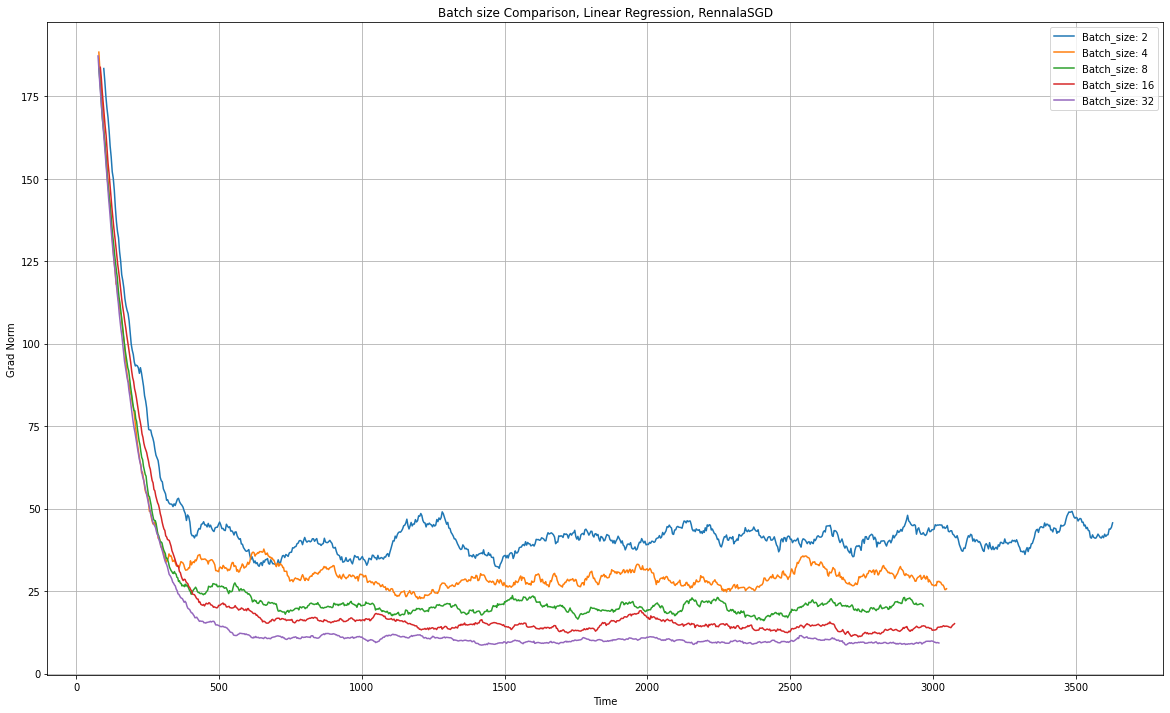

In [144]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sps
from functools import partial

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def compare_params(method_type, params, param_to_check):
    if param_to_check == "batch_size":
        
        times = dict()
        losses = dict()
        accs = dict()
        grads = dict()
        
        for param in tqdm(params):
            w = np.zeros(diabetes_X.shape[1]) 

            time_distributions = [sps.norm(i+1, scale=1) for i in range(param)]
            #batch_sizes = np.arange(1, 4 + 1) * 10
            
            if method_type == "MinibatchSGD":
                
                print(param)
                
                method = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=param) for i in range(param)], \
                                  learning_rate=lr)
                title = 'Batch size Comparison, Linear Regression, Minibatch'

                
            if method_type == "AsynchronousGD":
                
                print(param)
                
                method = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=param) for i in range(param)], \
                                  learning_rate=lr)
                title = 'Batch size Comparison, Linear Regression, AsynchronousGD'
   
            if method_type == "RennalaSGD":
                
                print(param)
                
                method = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, accuracy_fn, \
                              [partial(linear_regression_gradient, batch_size=param) for i in range(param)], \
                                  learning_rate=lr)
                method.set_batch_size(5)
                title = 'Batch size Comparison, Linear Regression, RennalaSGD'

            
            current_x, loss_history, computation_times, x_history = method.run_steps(n_iterations)
            accuracy = method.restore_accuracies()
            _, grad_norm = method.restore_gradients()
            times[param] = computation_times
            losses[param] = loss_history
            accs[param] = accuracy
            grads[param] = grad_norm
        
        plt.figure(figsize=(20, 12))
        for i in params:
            smoothed_grads = moving_average(grads[i])  # Применяем сглаживание
            smoothed_times = moving_average(times[i])  # Применяем сглаживание
            plt.plot(smoothed_times, smoothed_grads, label=f'Batch_size: {i}')
        
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Grad Norm')
        plt.legend()
        plt.grid(True)
        plt.show()

batch_params = [2, 4, 8, 16, 32]


compare_params(method_type="MinibatchSGD", params=batch_params, param_to_check="batch_size")
compare_params(method_type="AsynchronousGD", params=batch_params, param_to_check="batch_size")
compare_params(method_type="RennalaSGD", params=batch_params, param_to_check="batch_size")


## **LogReg on Mushroom**

In [149]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("prishasawhney/mushroom-dataset")

data = pd.read_csv(f"{path}/mushroom_cleaned.csv")

In [161]:
scaler = MinMaxScaler()

x = data.drop('class', axis=1).values
x = scaler.fit_transform(x)
y = 2*data['class'].values - 1

In [162]:
data_mushroom = (x, y)

In [165]:
lr = 0.01
w = np.zeros(x.shape[1])

n_workers = 4
time_distributions = [sps.norm(i+1, scale=26) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10

In [166]:
minibatch_sgd = MinibatchSGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
async_gd = AsynchronousGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd = RennalaSGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd.set_batch_size(5)

methods = {'Minibatch SGD' : minibatch_sgd,
           'Async GD' : async_gd,
           'Rennala SGD' : rennala_sgd}

In [167]:
times = dict()
losses = dict()
for method_name in methods:
    w = np.zeros(diabetes_X.shape[1])
    current_x, loss_history, computation_times, x_history = methods[method_name].run_steps(1000)
    times[method_name] = computation_times
    losses[method_name] = loss_history

[53506 10296 42663 34225 52670 28249 21524 17715 24460 15153]
(10, 8) (8,)
[23706 26736 38664 50900 35134 29068 45578 22684  5566  4449 52847  8588
 43877 26844 53135 30110 38924 53844  4155 52024]
(20, 8) (8,)
[38972 50080 13079  5361 49735 43929 17473 31834   900 14855 51786 40678
 26657 34787 19400  5332 45411 21832  4168 52430 53874  2441 52293 27708
 31846 10772  4631  2529 51001 52902]
(30, 8) (8,)
[44019 48338 50408 49632  3272 21295 49009 39576  3696 19232 40774 14814
  8406 31700 46608 40861 35552 50266 45339 36186  6613   549 30221 32172
 52328  5087  6690 44897 33962 11694 16974 49970 46678 40238 25735 46722
 16339 24688 36705   382]
(40, 8) (8,)
[14369 10686 37457 42849 12872 31054 44441 24577  1599 39192]
(10, 8) (8,)
[33962 38337  7396  6688 34169 51937 23448 52050  8239 15874 33428  7041
 35867 34074 42081 20020 40679 24880 48335 30935]
(20, 8) (8,)
[44081  3916 45096 10909 18173 37945 33501  6033 25141 16683  8698 40820
 40863 25807 21065 29816  8178 48196  7124  7223 5

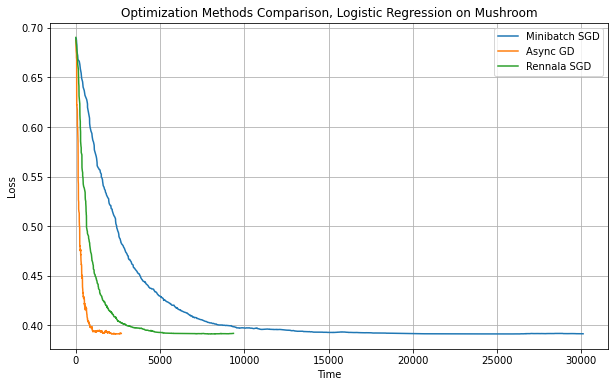

In [168]:
plt.figure(figsize=(10, 6))
for method_name in methods:
    plt.plot(times[method_name], losses[method_name], label=method_name)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Optimization Methods Comparison, Logistic Regression on Mushroom')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
np.linalg.norm(logistic_regression_gradient(data_mushroom, x_history[-1]))

0.014275443045136732

In [169]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sps
from functools import partial

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def compare_params(method_type, params, param_to_check):
    if param_to_check == "batch_size":
        
        times = dict()
        losses = dict()
        accs = dict()
        grads = dict()
        
        for param in tqdm(params):
            w = np.zeros(diabetes_X.shape[1]) 

            time_distributions = [sps.norm(i+1, scale=1) for i in range(param)]
            #batch_sizes = np.arange(1, 4 + 1) * 10
            
            if method_type == "MinibatchSGD":
                
                print(param)
                
                method = MinibatchSGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
                title = 'Batch size Comparison, Logistic Regression, Minibatch'

                
            if method_type == "AsynchronousGD":
                
                print(param)
                
                method = AsynchronousGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
                title = 'Batch size Comparison, Logistic Regression, AsynchronousGD'
   
            if method_type == "RennalaSGD":
                
                print(param)
                
                method = RennalaSGD(w, data_mushroom, time_distributions, logistic_regression_loss, accuracy_fn, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
                method.set_batch_size(5)
                title = 'Batch size Comparison, Logistic Regression, RennalaSGD'

            
            current_x, loss_history, computation_times, x_history = method.run_steps(n_iterations)
            accuracy = method.restore_accuracies()
            _, grad_norm = method.restore_gradients()
            times[param] = computation_times
            losses[param] = loss_history
            accs[param] = accuracy
            grads[param] = grad_norm
        
        plt.figure(figsize=(20, 12))
        for i in params:
            smoothed_grads = moving_average(grads[i])  # Применяем сглаживание
            smoothed_times = moving_average(times[i])  # Применяем сглаживание
            plt.plot(smoothed_times, smoothed_grads, label=f'Batch_size: {i}')
        
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Grad Norm')
        plt.legend()
        plt.grid(True)
        plt.show()

batch_params = [2, 4, 8, 16, 32]


compare_params(method_type="MinibatchSGD", params=batch_params, param_to_check="batch_size")
compare_params(method_type="AsynchronousGD", params=batch_params, param_to_check="batch_size")
compare_params(method_type="RennalaSGD", params=batch_params, param_to_check="batch_size")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

2


AssertionError: Number of gradient functions (4)               must match number of time distributions (2)

**NN on MNIST**

In [27]:
from torchvision import datasets, transforms

In [28]:
def load_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5, std 0.5
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    return train_dataset, test_dataset

In [29]:
mnist_train, mnist_test = load_mnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [01:08<00:00, 145453.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 290149.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2802490.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1228194.75it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [30]:
model = SimpleNN()

In [31]:
k = 10
subset_indices = torch.randperm(len(mnist_train))[:k]
subset_train = torch.utils.data.Subset(mnist_train, subset_indices)
train_loader = DataLoader(subset_train, batch_size=64, shuffle=True)


In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
num_param = sum(p.numel() for p in model.parameters())
num_param

12730

In [34]:
start = torch.rand((1, num_param))

In [35]:
minibatch_sgd = MinibatchSGD(start, mnist_train, time_distributions, partial(loss_from_vector, model=model, criterion=criterion), \
                              [partial(gradient_from_vector, model=model, criterion=criterion, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)

In [36]:
times = dict()
losses = dict()
w = np.zeros(diabetes_X.shape[1])
current_x, loss_history, computation_times, x_history = minibatch_sgd.run_steps(1)
times[method_name] = computation_times
losses[method_name] = loss_history

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:163: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asanyarray(a)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


AttributeError: 'torch.dtype' object has no attribute 'type'